May: Outline of the canyon rim and the depth of upwelling along it (for one time and time range).

In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import xarray as xr
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

from operator import itemgetter 

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

In [3]:
ts_data = sio.loadmat('../../mackenzie_canyon/conditions/data/for_stratification/canyonTSdata2.mat')
i_ref = 0
sal_ref = ts_data['salcanyon2'][:, i_ref]
dep_ref = ts_data['depthcanyon2'][:, i_ref]*-1

In [4]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/eventB_pulse10_bdy' 
gridT = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_T.nc')

depth_levels = np.asfarray(gridT['deptht'])
sal = np.asfarray(gridT['vosaline'])

# Defining the canyon rim

In [5]:
diffs_x = np.zeros([bathy.shape[0], bathy.shape[1]-1])

diffs_y = np.zeros([bathy.shape[0]-1, bathy.shape[1]])

for n in range(bathy.shape[0]):
    diffs_x[n, :] = abs(np.diff(bathy[n, :]))

for n in range(bathy.shape[1]):
    diffs_y[:, n] = np.diff(bathy[:, n])

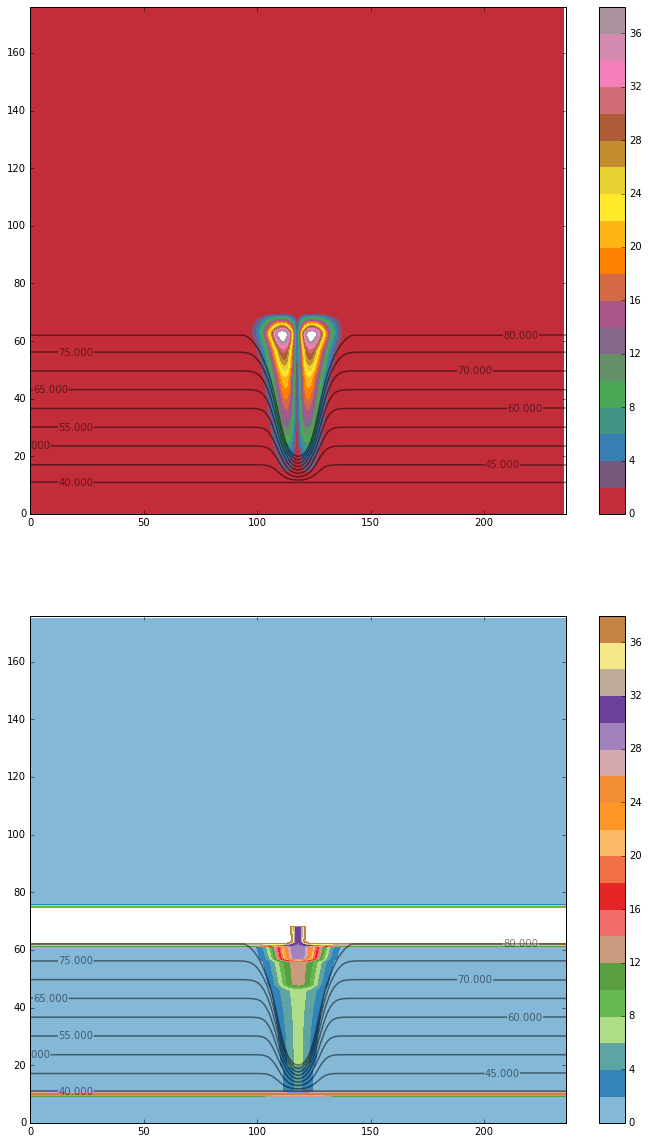

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 20))
c = ax1.contour(bathy[:,:], levels = np.arange(40,85,5), colors='k', linewidths=1.5, alpha=0.5)
ax1.clabel(c, inline=1, fontsize=10)

c = ax2.contour(bathy[:,:], levels = np.arange(40,85,5), colors='k', linewidths=1.5, alpha=0.5)
ax2.clabel(c, inline=1, fontsize=10)

cf_x = ax1.contourf(diffs_x, cmap = cm.Set1, levels=np.arange(0, 40, 2))
cf_y = ax2.contourf(diffs_y, cmap = cm.Paired, levels=np.arange(0, 40, 2))
fig.colorbar(cf_x, ax=ax1)
fig.colorbar(cf_y, ax=ax2)

In [7]:
possible_rim_points = np.where((abs(diffs_x) >= 2) & (abs(diffs_x) <= 4))
possible_rim_points_x = possible_rim_points[1]
possible_rim_points_y = possible_rim_points[0]

vertical = np.where((abs(diffs_y) >= 2) & (abs(diffs_y) <= 4))
xvertical = vertical[1]
yvertical = vertical[0]

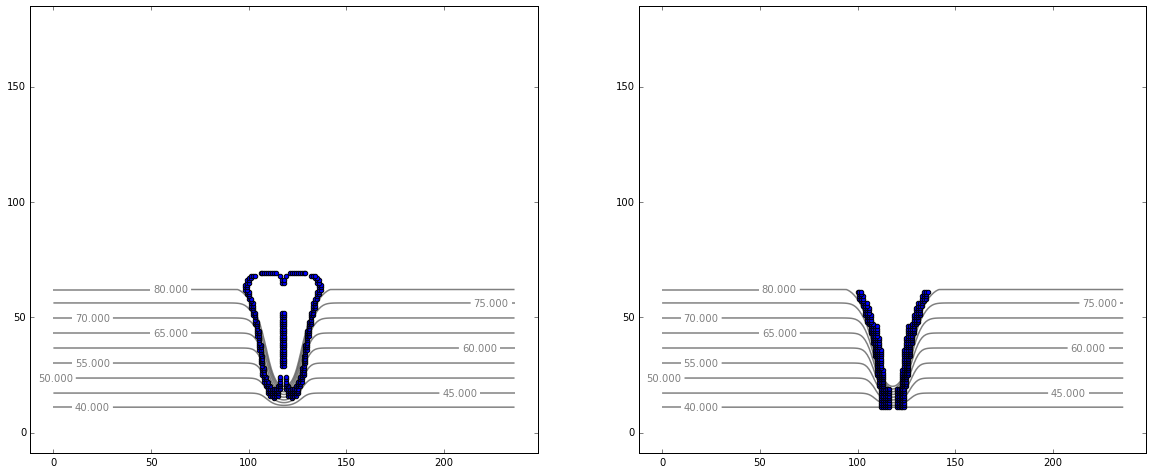

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 8))
c = ax1.contour(bathy[:,:], levels = np.arange(40,85,5), colors='k', linewidths=1.5, alpha=0.5)
ax1.clabel(c, inline=1, fontsize=10)

c = ax2.contour(bathy[:,:], levels = np.arange(40,85,5), colors='k', linewidths=1.5, alpha=0.5)
ax2.clabel(c, inline=1, fontsize=10)

ax1.scatter(possible_rim_points_x, possible_rim_points_y)
ax2.scatter(xvertical, yvertical)

In [9]:
# many points satisfy the gradient condition
# the unique y coordinates are found for all possible points
unique_ys = np.unique(possible_rim_points_y)
rim_inds_full = np.zeros([len(unique_ys), 3])
for n in range(len(unique_ys)):
    # isolate one of the unique y-coordinates
    individual_y = unique_ys[n]
    # there will be many points along the same y-coordinate
    # this finds the indices for all points along the unique y-coordinate
    inds_individual_y = np.where(possible_rim_points_y==individual_y)
    # this finds the corresponding x-coordinates for the unique y-coordinate
    inds_x_for_individual_y = itemgetter(*inds_individual_y)(possible_rim_points_x)
    # we now have all x-coordinates along the unique y-coordinate
    # this gives the smallest x-coordinate (west)
    individual_x_min = inds_x_for_individual_y.min()
    # this gives the biggest x-coordinate (east)
    individual_x_max = inds_x_for_individual_y.max()
    # they are stored into one n-d array
    rim_inds_full[n,0] = individual_y
    rim_inds_full[n,1] = individual_x_min
    rim_inds_full[n,2] = individual_x_max
    


In [10]:
ind_for_shelf_break = (np.abs(bathy[:,0]-80)).argmin()
ind_end_rim = np.where(rim_inds_full[:,0] == ind_for_shelf_break)[0][0]
rim_inds = rim_inds_full[:ind_end_rim, :]

(47, 3)


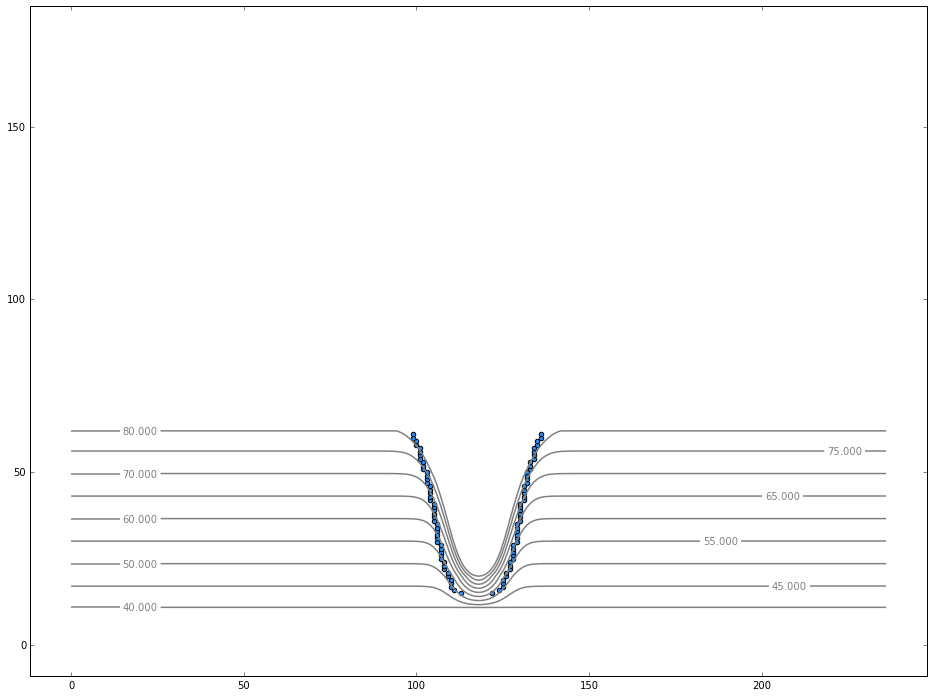

In [11]:
fig, ax = plt.subplots(1,1,figsize=(bathy.shape[1]/bathy.shape[0]*12, 12))
c = ax.contour(bathy[:,:], levels = np.arange(40,85,5), colors='gray', linewidths=1.5)
ax.clabel(c, inline=1, fontsize=10)

ax.scatter(rim_inds[:,1], rim_inds[:,0], c='dodgerblue')
ax.scatter(rim_inds[:,2], rim_inds[:,0], c='dodgerblue')

print(rim_inds.shape)

# Finding depth of upwelling using previous functions at one time

In [12]:
time_shot=400; sal_full = sal
ind_nanmax_full = functions_upwelling_depth.get_nanmax_ind_full(time_shot, sal_full)
ind_nanmax_full.shape

(177, 237)

In [13]:
sal_profiles_rim_left = functions_upwelling_depth.get_sal_profiles_rim(rim_inds[:,0], rim_inds[:,1], time_shot, sal_full)
sal_profiles_rim_right = functions_upwelling_depth.get_sal_profiles_rim(rim_inds[:,0], rim_inds[:,2], time_shot, sal_full)

In [14]:
depth_change_left, d_new_left = functions_upwelling_depth.calculate_ED_rim(sal_profiles_rim_left, sal_ref, dep_ref, depth_levels)
depth_change_right, d_new_right = functions_upwelling_depth.calculate_ED_rim(sal_profiles_rim_right, sal_ref, dep_ref, depth_levels)

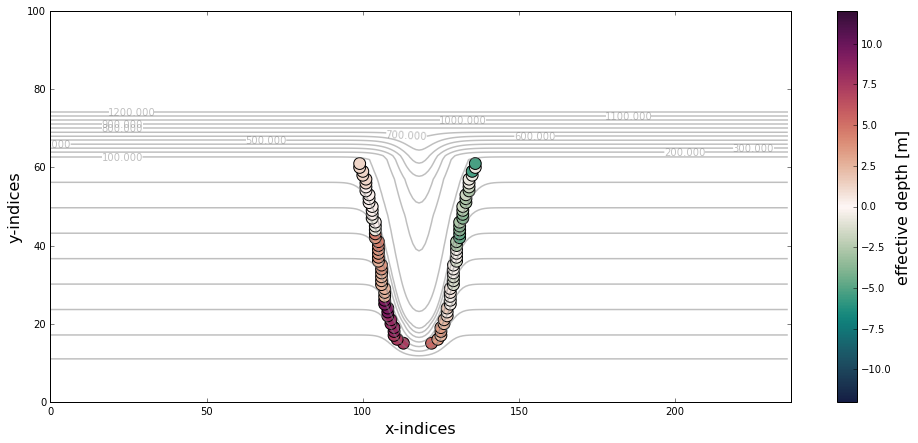

In [15]:
fig, ax = plt.subplots(1,1,figsize=(bathy.shape[1]/100*7, 7))
c = ax.contour(bathy[:,:], levels = np.arange(40,80,5), colors='gray', linewidths=1.5, alpha=0.5)
c = ax.contour(bathy[:,:], levels = np.arange(100,1300,100), colors='gray', linewidths=1.5, alpha=0.5)
ax.clabel(c, inline=1, fontsize=10)

ax.scatter(rim_inds[:,1], rim_inds[:,0], c='dodgerblue')
ax.scatter(rim_inds[:,2], rim_inds[:,0], c='dodgerblue')

s = ax.scatter(rim_inds[:,1], rim_inds[:,0], c=depth_change_left, cmap = cmo.cm.curl, vmin=-12, vmax=12, s=140)
s = ax.scatter(rim_inds[:,2], rim_inds[:,0], c=depth_change_right, cmap = cmo.cm.curl, vmin=-12, vmax=12, s=140)

ax.set_xlim([0,bathy.shape[1]])
ax.set_ylim([0,100])

cb=fig.colorbar(s, ax=ax)
cb.set_label('effective depth [m]', fontsize=16)

ax.set_ylabel('y-indices', fontsize=16)
ax.set_xlabel('x-indices', fontsize=16)

# Finding depth of upwelling for time range

In [17]:
def get_Z_model(sal, time_ind_adv):
    sal_full = sal
    ##### why is this 24 there?!?!
    time_shots_adv = np.arange(time_ind_adv, time_ind_adv+24)
    ED_left = np.zeros([time_shots_adv.shape[0], rim_inds.shape[0]])
    ED_right = np.zeros_like(ED_left)

    for time_shot, n in zip(time_shots_adv, np.arange(len(time_shots_adv))):

        ind_nanmax_full = functions_upwelling_depth.get_nanmax_ind_full(time_shot, sal_full)


        sal_profiles_rim_left = functions_upwelling_depth.get_sal_profiles_rim(rim_inds[:,0], rim_inds[:,1], time_shot, sal_full)
        sal_profiles_rim_right = functions_upwelling_depth.get_sal_profiles_rim(rim_inds[:,0], rim_inds[:,2], time_shot, sal_full)


        depth_change_left, d_new_left = functions_upwelling_depth.calculate_ED_rim(sal_profiles_rim_left, sal_ref, dep_ref, depth_levels)
        depth_change_right, d_new_right = functions_upwelling_depth.calculate_ED_rim(sal_profiles_rim_right, sal_ref, dep_ref, depth_levels)

        ED_left[n, :] = depth_change_left
        ED_right[n, :] = depth_change_right
        
    ED_left_mean = np.mean(ED_left, axis=0)
    ED_right_mean = np.mean(ED_right, axis=0)
    Z_model = np.max([ED_left_mean.max(), ED_right_mean.max()])
    
    print(ED_left.shape, ED_left_mean.shape)
    
    return ED_left_mean, ED_right_mean, Z_model

In [18]:
time_ind_adv = time_shot
ED_left_mean, ED_right_mean, Z_model = get_Z_model(sal, time_ind_adv)

(24, 47) (47,)


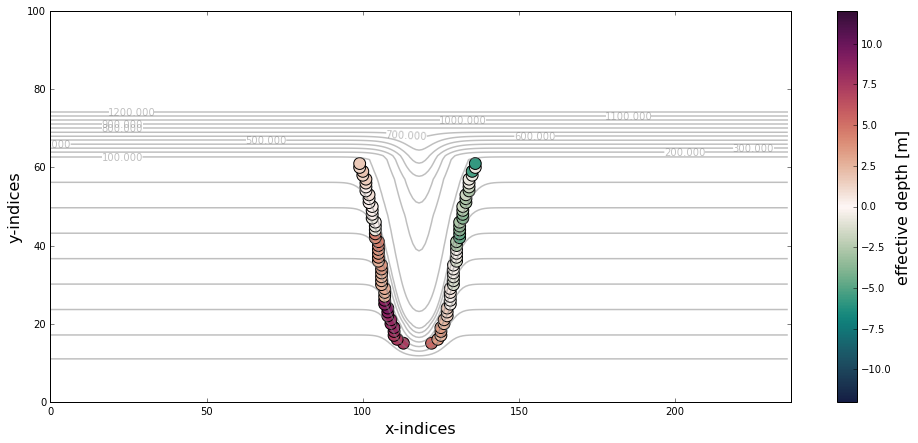

In [19]:
fig, ax = plt.subplots(1,1,figsize=(bathy.shape[1]/100*7, 7))
c = ax.contour(bathy[:,:], levels = np.arange(40,80,5), colors='gray', linewidths=1.5, alpha=0.5)
c = ax.contour(bathy[:,:], levels = np.arange(100,1300,100), colors='gray', linewidths=1.5, alpha=0.5)
ax.clabel(c, inline=1, fontsize=10)

ax.scatter(rim_inds[:,1], rim_inds[:,0], c='dodgerblue')
ax.scatter(rim_inds[:,2], rim_inds[:,0], c='dodgerblue')

s = ax.scatter(rim_inds[:,1], rim_inds[:,0], c=ED_left_mean, cmap = cmo.cm.curl, vmin=-12, vmax=12, s=140)
s = ax.scatter(rim_inds[:,2], rim_inds[:,0], c=ED_right_mean, cmap = cmo.cm.curl, vmin=-12, vmax=12, s=140)

ax.set_xlim([0,bathy.shape[1]])
ax.set_ylim([0,100])

cb=fig.colorbar(s, ax=ax)
cb.set_label('effective depth [m]', fontsize=16)

ax.set_ylabel('y-indices', fontsize=16)
ax.set_xlabel('x-indices', fontsize=16)

# Checking

In [22]:
depth_change_left - ED_left_mean

array([ -4.44089210e-15,  -4.44089210e-15,  -4.44089210e-15,
         4.53549970e-01,  -5.32907052e-15,  -5.32907052e-15,
        -5.32907052e-15,  -5.32907052e-15,   5.36011002e-01,
         4.12316155e-02,   4.94779386e-01,   5.36011002e-01,
         0.00000000e+00,   0.00000000e+00,  -2.06151081e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.06151081e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.64920065e-01,   0.00000000e+00,
        -4.12300163e-01,   1.64920065e-01,   0.00000000e+00,
         0.00000000e+00,   4.94736213e-01,   0.00000000e+00,
         8.24560355e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -5.77189451e-01,
         0.00000000e+00,  -4.12278179e-02,   0.00000000e+00,
        -3.71048563e-01,   0.00000000e+00,  -6.18414272e-01,
         0.00000000e+00,  -4.53503799e-01])